In [65]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from geopy.distance import geodesic

from sklearn import linear_model, model_selection, metrics

## Load train and test data

In [66]:
# train set
df_mess_train = pd.read_csv('mess_train_list.csv')

# test set
df_mess_test = pd.read_csv('mess_test_list.csv')

# position associated to train set
pos_train = pd.read_csv('pos_train_list.csv') 

In [67]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [68]:
print(df_mess_train.shape)
df_mess_train.describe()

(39250, 8)


,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [69]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [70]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


## Prepare data

In [71]:
# determine all Base stations that received at least 1 message
trainBs  = np.unique(df_mess_train['bsid'])
testBs   = np.unique(df_mess_test['bsid'])
listOfBs = np.union1d(trainBs, testBs) 
testOnlyBs = np.lib.arraysetops.setdiff1d(testBs, trainBs)

print(f"Number of stations: %d, test only %d" % (len(listOfBs), len(testOnlyBs)))

Number of stations: 259, test only 8


In [72]:
df_mess_train['did'].unique().shape

(113,)

In [73]:
def tan_degree(x):
    """ Tangent for degree values (latitude) """
    return np.tan(x * np.pi / 180)

def arctan_degree(x):
    """ arc tan to degree """
    return np.arctan(x) * 180 / np.pi

def deg_to_complex(x):
    """ Degree angle to corresponding complex """
    xx = x * np.pi / 180
    return np.cos(xx), np.sin(xx)

def complex_to_deg(z):
    """ Complex to degree angle """
    return np.angle(z[:,0] + 1j*z[:,1], deg=True)

In [74]:
def feat_mat_const(df, listOfBs, keepMax=2):
    """ Feature Matrix construction, 
        Return a two-way table with BS on horizontal axis
        Keep at most keepMax BS per message
    """
    
    # Keep at max keepMax base-stations per message
    df = df.groupby('messid'). \
        apply(lambda x: x.sort_values(['rssi'], ascending=False)). \
        reset_index(drop=True).groupby('messid').head(3)
    
    # Add active column
    df['active'] = 1
    
    # Add tangent of latitude
    df['bs_tanlat'] = tan_degree(df['bs_lat'])
    
    r,i = deg_to_complex(df['bs_lng'])
    df['bs_coslng'] = r
    df['bs_sinlng'] = i
    
    # Add extra rows for Base-stations that are not present in this dataset
    usedBs = np.unique(df['bsid'])
    missingBs = np.lib.arraysetops.setdiff1d(listOfBs, usedBs)
    df2 = pd.DataFrame([['-1', bs, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] for bs in missingBs], columns=df.columns)
    df = df.append(df2)
    
    #df = df[df['bs_lat'] < 50]
    
    # Pivot BS to columns
    df = df.pivot_table(index='messid', 
                                    values=['active', 'nseq', 'rssi', 'bs_tanlat', 'bs_coslng', 'bs_sinlng'], 
                                    columns=['bsid'],
                                    fill_value=0)
    resDf = df.reorder_levels([1, 0], axis=1).sort_index(level=0, axis=1)
    return resDf.drop(['-1'])

In [171]:
def feat_mat_const2(df, listOfBs, keepMax=2):
    """ Feature Matrix construction """
    
    aggCols = ['pivot_lat', 'pivot_lng',
                'bs0_deltalat', 'bs0_deltalng', 'bs0_rssi', 
               'bs1_deltalat', 'bs1_deltalng', 'bs1_rssi',
               'bs2_deltalat', 'bs1_deltalng', 'bs1_rssi']
    
    def aggregateBaseStations(groupBy):
        """ From a RSSI sorted DataFrameGroupBy
            create a dataframe with the 3 best BS 
        """
        bsSet = groupBy.iloc[:3]
        w = bsSet['rssi'] / np.sum(bsSet['rssi'])
        lat = np.average(bsSet['bs_lat'], weights=w)
        lng = bsSet['bs_lng'].mean()
        nbs0 = nbs1 = nbs2 = [0, 0, -1e5]
        if len(bsSet) > 0:
            b = bsSet.iloc[0]
            nbs0 = [b['bs_lat'] - lat, b['bs_lng'] - lng, b['rssi']]
        if len(bsSet) > 1:
            b = bsSet.iloc[1]
            nbs1 = [b['bs_lat'] - lat, b['bs_lng'] - lng, b['rssi']]
        if len(bsSet) > 2:
            b = bsSet.iloc[2]
            nbs2 = [b['bs_lat'] - lat, b['bs_lng'] - lng, b['rssi']]
                
        return pd.DataFrame(np.concatenate([[lat, lng], nbs0, nbs1, nbs2]).reshape(1, 11), 
                            columns=aggCols)
            
    
    # Keep at max keepMax base-stations per message
    df = df.groupby('messid'). \
        apply(lambda x: x.sort_values(['rssi'], ascending=False)). \
        reset_index(drop=True).groupby('messid').apply(aggregateBaseStations)
    
    return df

In [76]:
def ground_truth_const(df_mess_train, pos_train):
    """ Ground truth construction """
    
    df = pd.concat([df_mess_train[['messid']], pos_train], axis=1)
    df_mean = df.groupby('messid').mean()

    return df_mean['lat'], df_mean['lng']

In [172]:
df_feat = feat_mat_const2(df_mess_train, listOfBs)
df_feat.head()

,,pivot_lat,pivot_lng,bs0_deltalat,bs0_deltalng,bs0_rssi,bs1_deltalat,bs1_deltalng,bs1_rssi,bs2_deltalat,bs1_deltalng,bs1_rssi
messid,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0,39.647945,-104.953819,-0.030151,-0.001098,-121.500000,0.029307,0.001098,-125.000000,0.000000,0.000000,-100000.000000
573bf3533e952e19126b256a,0,39.612745,-105.008827,0.000000,0.000000,-134.000000,0.000000,0.000000,-100000.000000,0.000000,0.000000,-100000.000000
573c0cd0f0fe6e735a699b93,0,39.753734,-105.001109,-0.021689,0.027458,-100.000000,-0.030584,0.044893,-120.000000,0.044235,-0.072351,-132.000000
573c1272f0fe6e735a6cb8bd,0,39.656684,-105.022968,0.048203,0.006576,-123.333333,-0.002002,-0.020717,-123.666667,-0.043939,0.014141,-129.666667
573c8ea8864fce1a9a5fbf7a,0,39.766410,-105.036610,-0.011391,-0.006704,-98.000000,-0.004777,0.010857,-106.666667,0.015054,-0.004153,-108.000000


In [173]:
df_feat.shape

(6068, 11)

In [174]:
df_mess_train.head(1)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917


In [175]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(6068,)

## Make regressor and prediction using the train set

In [176]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test, trigo):
    
    """ train regressor and make prediction in the train set
      Input: df_feat: feature matrix used to train regressor
             ground_truth_lat: df_feat associated latitude
             ground_truth_lng: df_feat associated longitude
             df_test: data frame used for prediction
      Output: y_pred_lat, y_pred_lng
    """

    X_train = np.array(df_feat);
    reg = linear_model.LinearRegression()

    if trigo:
        ground_truth_tanlat = tan_degree(ground_truth_lat)
        ground_truth_lng_r, ground_truth_lng_i = deg_to_complex(ground_truth_lng)
        ground_truth = np.c_[ground_truth_tanlat, ground_truth_lng_r, ground_truth_lng_i]
        reg.fit(X_train, ground_truth);
        y_pred = reg.predict(df_test) 
        return arctan_degree(y_pred[:,0]), complex_to_deg(y_pred[:,1:]), reg

    else:
        ground_truth = np.c_[ground_truth_lat, ground_truth_lng]
        reg.fit(X_train, ground_truth);
        y_pred = reg.predict(df_test) 
        return y_pred[:,0], y_pred[:,1], reg

In [177]:
y_pred_lat, y_pred_lng, reg = regressor_and_predict(df_feat, 
                                        ground_truth_lat, ground_truth_lng, df_feat, False)

In [178]:
reg.coef_, reg.intercept_

(array([[ 5.39762009e-01, -3.62529941e-01,  5.92349022e-01,
         -2.77489471e-01,  2.48946962e-03, -6.07649159e-02,
          1.61289249e-01, -6.09219348e-08,  6.24685280e-03,
          1.16200222e-01, -1.26002441e-07],
        [-4.15092449e-01,  2.79774101e-01, -4.53182591e-01,
          2.11853970e-01, -1.78567432e-03,  2.72679119e-02,
         -1.10994500e-01,  8.71318986e-08,  1.20660058e-02,
         -1.00859470e-01,  7.93059334e-08]]),
 array([-19.50725768, -59.34699722]))

## Cross validation

In [179]:
def cross_val_fit_predict(df_feat, ground_truth_lat, ground_truth_lng, trigo):
    reg = linear_model.LinearRegression()
    
    if trigo:
        ground_truth_lng_r, ground_truth_lng_i = deg_to_complex(ground_truth_lng)
        ground_truth = np.c_[tan_degree(ground_truth_lat), ground_truth_lng_r, ground_truth_lng_i]

        y_pred = model_selection.cross_val_predict(reg, df_feat, ground_truth, cv=5)

        return arctan_degree(y_pred[:,0]), complex_to_deg(y_pred[:,1:]), reg

    else:
        ground_truth = np.c_[ground_truth_lat, ground_truth_lng]

        y_pred = model_selection.cross_val_predict(reg, df_feat, ground_truth, cv=5)

        return y_pred[:,0], y_pred[:,1]

In [180]:
#y_pred_lat, y_pred_lng = cross_val_fit_predict(df_feat, 
# ground_truth_lat, ground_truth_lng, True)

y_pred_lat, y_pred_lng = cross_val_fit_predict(df_feat, 
                                    ground_truth_lat, ground_truth_lng, False)

## Evaluate result

In [181]:
def vincenty_vec(vec_coord):
    """ Now using geodesic distance instead of Vincenty """
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] != 4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [geodesic(v[0:2], v[2:]).meters for v in vec_coord]

    return vin_vec_dist

In [182]:
# evaluate distance error for each predicted point
def eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

## Plot error distribution

In [183]:
def plotError(err_vec):
    
    err80 = np.percentile(err_vec, 80)
    
    print(f"error @ 80% = {err80:.1f} m")
    
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 

    plt.figure()
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0,
             label="Opt LLR", c='blue')

    # plot error @ 80%
    plt.axvline(x=err80/1000., ymin=0, ymax=100,
                linestyle='dashed', color='red')

    plt.xlabel('Distance Error (km)')
    plt.ylabel('Cum proba (%)')
    plt.axis([0, 30, 0, 100]) 

    plt.title('Error Cumulative Probability')
    plt.legend()

    plt.grid()

In [184]:
err_vec = eval_geoloc(ground_truth_lat, ground_truth_lng, y_pred_lat, y_pred_lng)

error @ 80% = 8296.0 m


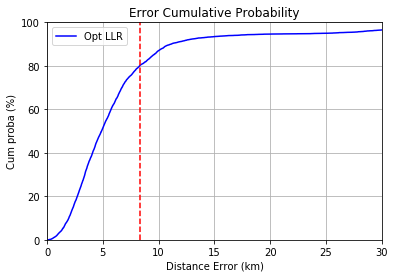

In [185]:
plotError(err_vec)

### Analysis

##### Mean square error

In [186]:
metrics.mean_squared_error(ground_truth_lat, y_pred_lat), \
metrics.mean_squared_error(ground_truth_lng, y_pred_lng)

(0.038705421931363615, 0.02347471827595562)

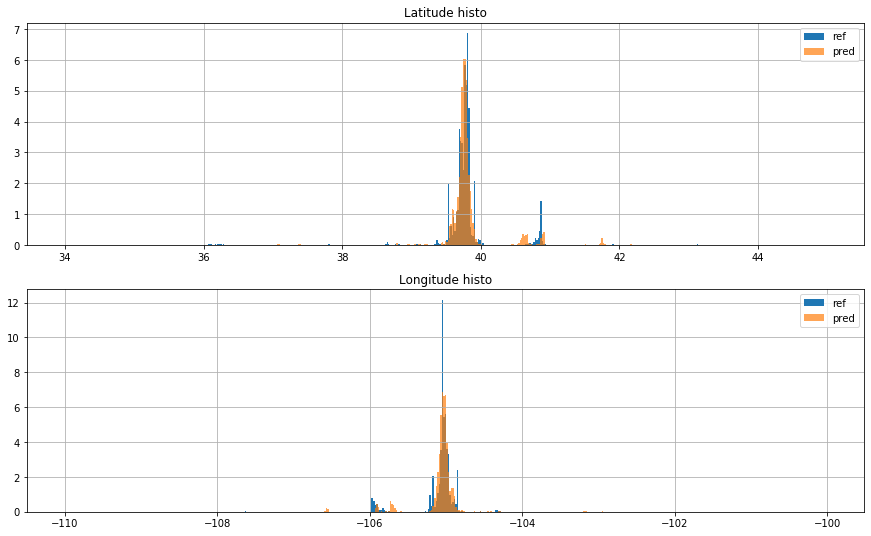

In [205]:
fig, axes = plt.subplots(2, 1, figsize=(15, 9))
latBins = np.arange(34, 45, 0.02) #range(-91, 92)
axes[0].hist(ground_truth_lat, label='ref', bins=latBins, density=True)
axes[0].hist(y_pred_lat, label='pred', alpha=0.7, bins=latBins, density=True)
axes[0].set_title('Latitude histo')
axes[0].legend()
axes[0].grid()
lngBins = np.arange(-110, -100, 0.02) #range(-181, 182)
axes[1].hist(ground_truth_lng, label='ref', bins=lngBins, density=True)
axes[1].hist(y_pred_lng, label='pred', alpha=0.7, bins=lngBins, density=True)
axes[1].set_title('Longitude histo')
axes[1].legend()
axes[1].grid()

## Study implausible outliers

May happened when regressing on latitude and longitude angles:
- Latitude lower than -90 degrees or greater than 90 degrees
- Longitude lower than -180 degrees or greater than 180 degrees (which is an indicator more than an issue since we could wrap these longitudes)

In [193]:
(y_pred_lat < -85).sum(), (y_pred_lng < -180).sum(), (y_pred_lat > 85).sum(), (y_pred_lng > 180).sum()

(0, 0, 0, 0)

In [199]:
plausible_lat = (y_pred_lat > -80) & (y_pred_lat < 80)
has_implausible_lat = (plausible_lat.sum() != len(plausible_lat))
(plausible_lat.mean(),
metrics.mean_squared_error(ground_truth_lat[plausible_lat], y_pred_lat[plausible_lat]))

(1.0, 0.038705421931363615)

In [189]:
if has_implausible_lat:
    plt.scatter(ground_truth_lng[~plausible_lat], ground_truth_lat[~plausible_lat])
    plt.scatter(y_pred_lng[~plausible_lat], y_pred_lat[~plausible_lat])

In [190]:
if has_implausible_lat:
    firstInplausible = list(plausible_lat).index(False)
    firstInplausible, y_pred_lat[firstInplausible], y_pred_lng[firstInplausible]

In [191]:
if has_implausible_lat:
    df4 = df_feat.iloc[firstInplausible]
    firstImplausibleMessid = df4.name
    df4 = df4.unstack()
    df4[df4['active'] == 1]

In [192]:
plausible_lng = (y_pred_lng > -180) & (y_pred_lng < 180)

(plausible_lng.mean(),
metrics.mean_squared_error(ground_truth_lng[plausible_lng], y_pred_lng[plausible_lng]) )

(1.0, 0.02347471827595562)

In [194]:
(plausible_lat ^ plausible_lng).sum(), (plausible_lat & plausible_lng).sum() # XOR

(0, 6068)

Outliers are the same on latitude and longitude

Let's compute the error without the outliers:

In [200]:
if has_implausible_lat:
    err_vec_plausible = eval_geoloc(ground_truth_lat[plausible_lat], ground_truth_lng[plausible_lat], 
                                y_pred_lat[plausible_lat], y_pred_lng[plausible_lat])
    plotError(err_vec_plausible)

## Construct test prediction

In [196]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [197]:
df_feat_test = feat_mat_const2(df_mess_test, listOfBs)
df_feat.shape, df_feat_test.shape

((6068, 11), (5294, 11))

In [201]:
y_pred_test_lat, y_pred_test_lng, reg = regressor_and_predict(df_feat, ground_truth_lat, 
                                                    ground_truth_lng, df_feat_test, False)

In [202]:
test_res = pd.DataFrame(np.array([y_pred_test_lat, y_pred_test_lng]).T, columns = ['lat', 'lng'])
test_res = pd.concat([df_mess_test['messid'], test_res], axis=1)

In [203]:
test_res.head()

,messid,lat,lng
0,573be2503e952e191262c351,39.803868,-105.078387
1,573c05f83e952e1912758013,39.803188,-105.074952
2,573c05f83e952e1912758013,39.679201,-104.981178
3,573c05f83e952e1912758013,39.794998,-105.071735
4,573c05f83e952e1912758013,39.675467,-104.978499


In [ ]:
test_res.to_csv('pred_pos_test_list.csv', index=False)